# The Clear Tutorial for Attention Mechanism in Transformers(Self-Attention to Causal Self-Attention)

[Source from Medium](https://medium.com/@tejaswi_kashyap/unpacking-attention-in-transformers-from-self-attention-to-causal-self-attention-21fa6824acd8)

In [2]:
# !pip install torch -q

## Self-Attention

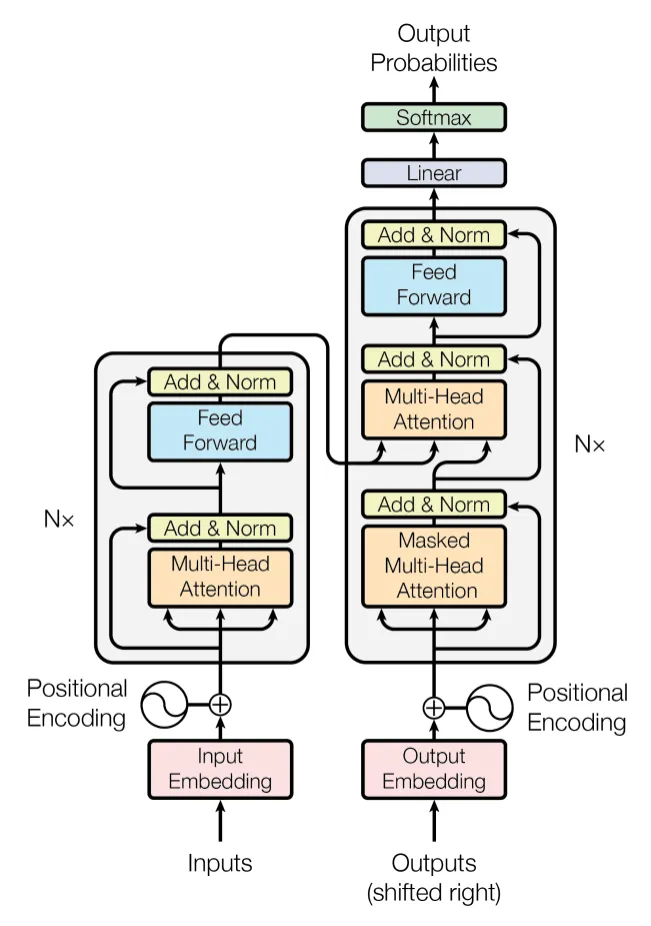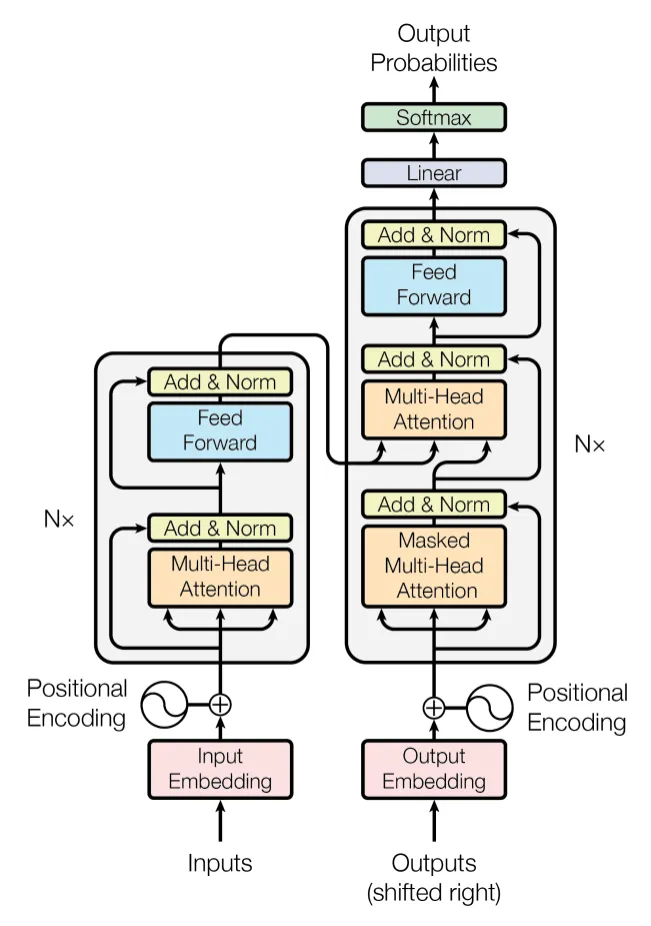

### Embedding an Input Sentence

### Dictionary 

In [3]:
sentence = 'The sun rises in the east'

dc = {s:i for i,s in enumerate(sorted(sentence.split()))}

print(dc)

{'The': 0, 'east': 1, 'in': 2, 'rises': 3, 'sun': 4, 'the': 5}


### Integer representation for the sentence

In [4]:
import torch

sentence_int = torch.tensor(
    [dc[s] for s in sentence.split()]
)
print(sentence_int)
                            

tensor([0, 4, 3, 2, 5, 1])


### Embedding Layer

In [5]:
vocab_size = 50_000

torch.manual_seed(123)
embed = torch.nn.Embedding(vocab_size, 3)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035],
        [ 0.1794,  1.8951,  0.4954],
        [-1.1925,  0.6984, -1.4097],
        [-0.2196, -0.3792,  0.7671],
        [ 0.2692, -0.0770, -1.0205],
        [-0.5880,  0.3486,  0.6603]])
torch.Size([6, 3])


### Defining the Weight Matrices for Scaled Dot-Product Attention

Now that we've embedded the input, let's explore the self-attention mechanism, specifically the widely-used scaled dot-product attention, which is a key element of transformer models.

The scaled dot-product attention mechanism is a key component of the transformer architecture. This mechanism uses three weight matrics: Wq, Wk, and Wv. These matrices are optimized during model training and transform input data.

### Query, Key, and Value Tranformations

The weight matrices project input data into three componenets:

1. Query(q)
2. Key(k)
3. Value(v)

These components are calculated through matrix multiplication:

- Query: q(i) = x(i)Wq
- Key: k(i) = x(i)Wk
- Value: v(i) = x(i)Wv

Here, 'i' indicates the token position in the input sentence of lenght T.

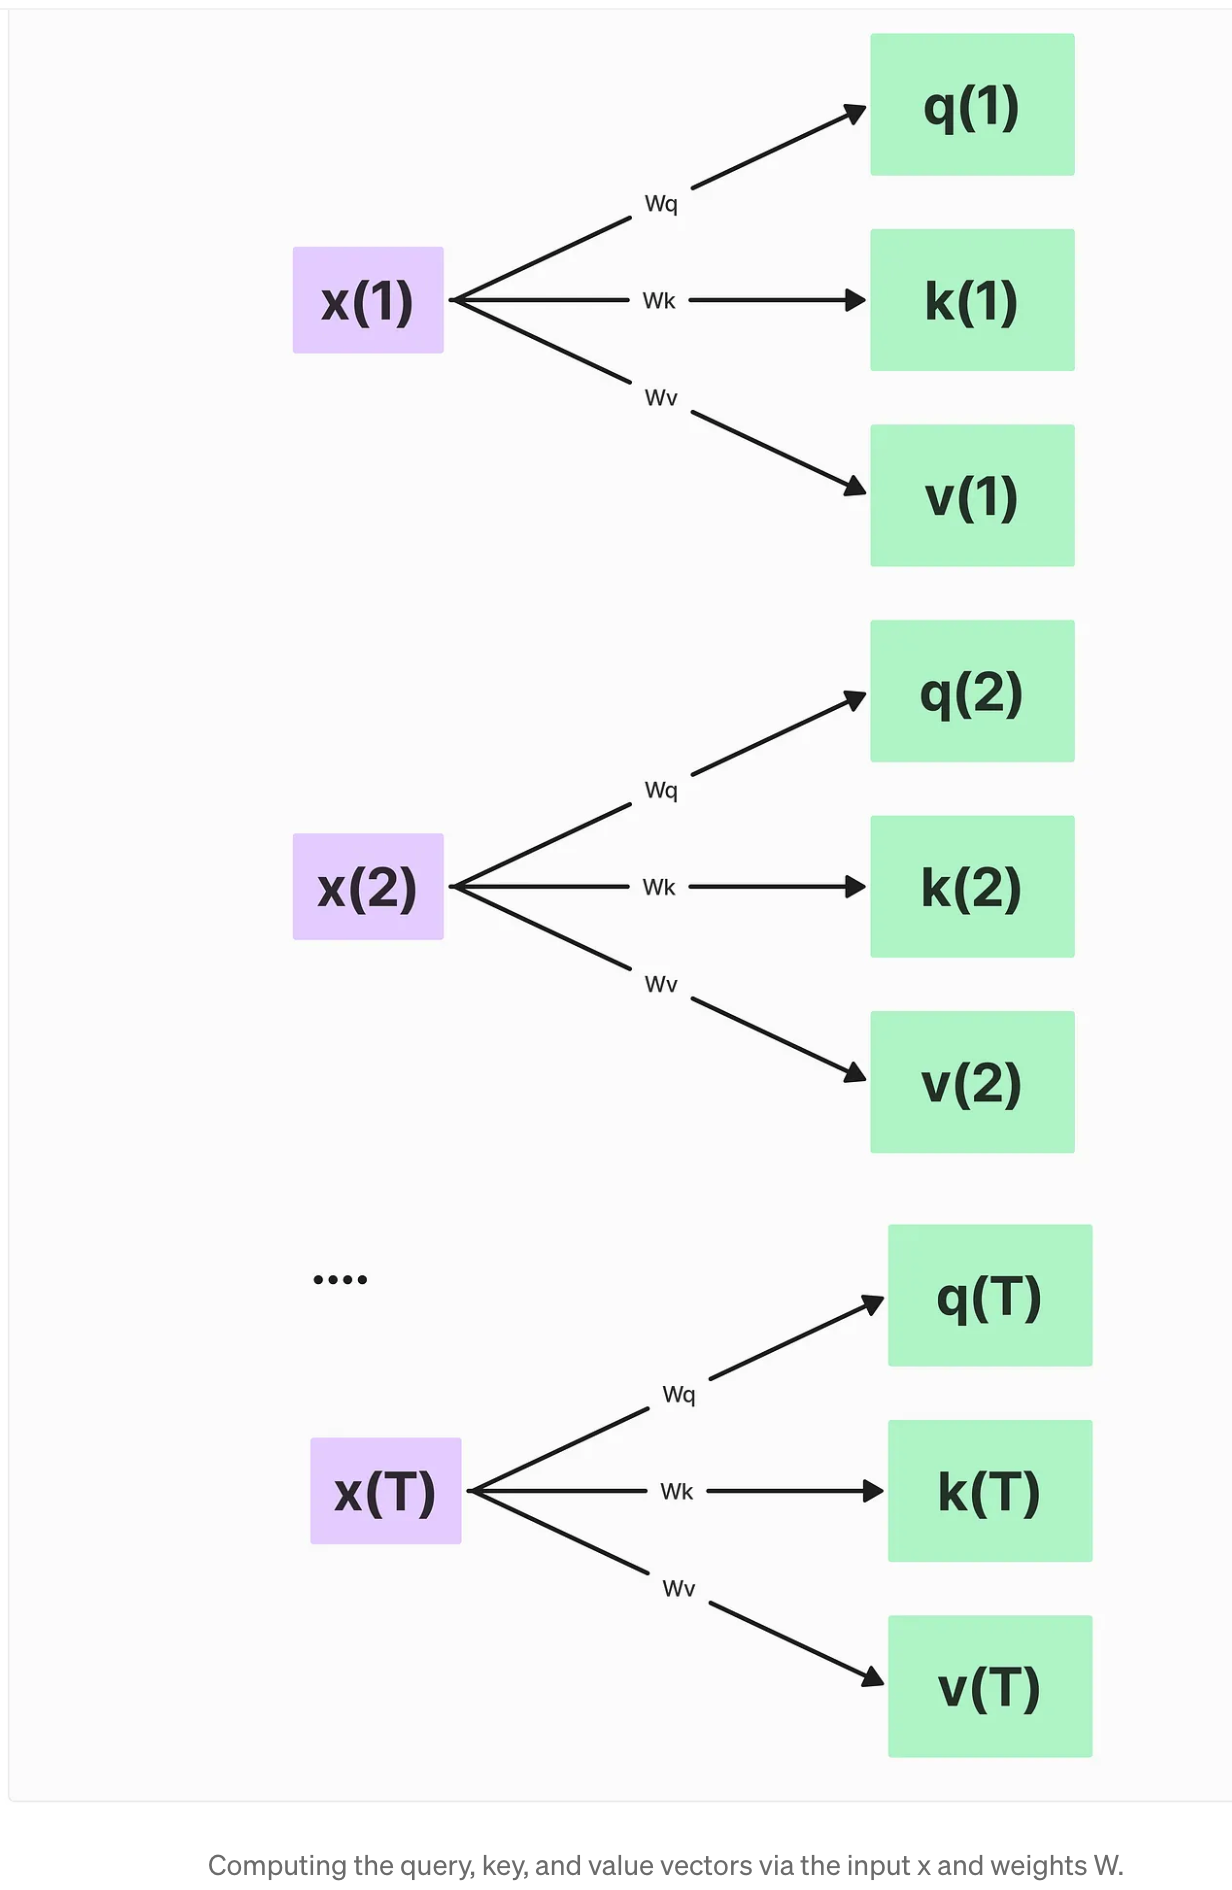

[source image](https://medium.com/@tejaswi_kashyap/unpacking-attention-in-transformers-from-self-attention-to-causal-self-attention-21fa6824acd8)

We're essentially taking each input token x(i) and projecting it into these three different spaces.

Now, let's talk about dimensions. Both 1(i) and k(i) are vectores with dk elements. The projection matrices Wq and Wk are shaped d x dk, while Wv is d x dv. Here, d is the size of each word vector x.

An important note: q(i) and k(i) must have the same number of elements(dq=dk) because we'll be computing their dot cproduct later. Many large languge models set dq = dvk = dv for simplicity, but the size of v(i) can be different if needed.



In [6]:
embedded_sentence.shape

torch.Size([6, 3])

In [7]:

torch.manual_seed(123)

d = embedded_sentence.shape[1]

d_q, d_k, d_v = 2, 2, 4

W_query = torch.nn.Parameter(torch.rand(d, d_q))
W_key = torch.nn.Parameter(torch.rand(d, d_k))
W_value = torch.nn.Parameter(torch.rand(d, d_v))

In [8]:
W_query.shape

torch.Size([3, 2])

By manipulating these matrices and dimenions, we can control how our model attends to different parts of the input, allowing it to capture complex relationship and dependencies in the data.

### Calculating Unnormalized Attention Weights in Self-Attention Mechanism 

Let's explore how we can compute the unnormalized attention weights, a crucial step in the self-attention mechanism. We'll focus on the second input element as our query for this example.

First, we project our second input element into query, key, and value spaces:


In [9]:
x_3 = embedded_sentence[2]  # Third element (index 2)
query_3 = x_3 @ W_query
key_3 = x_3 @ W_key
value_3 = x_3 @ W_value

print("Query shape:", query_3.shape)
print("Key shape:", key_3.shape)
print("Value shape:", value_3.shape)

Query shape: torch.Size([2])
Key shape: torch.Size([2])
Value shape: torch.Size([4])


Next, we’ll compute keys and values for all input elements:

In [10]:
keys = embedded_sentence @ W_key
values = embedded_sentence @ W_value

print("All keys shape:", keys.shape)
print("All values shape:", values.shape)

All keys shape: torch.Size([6, 2])
All values shape: torch.Size([6, 4])


Now, let’s calculate the unnormalized attention weights. These are computed as the dot product between our query and each key. We’ll use our query_3 as an example:

In [11]:
omega_3 = query_3 @ keys.T
print("Unnormalized attention weights for query 3:")
print(omega_3)

Unnormalized attention weights for query 3:
tensor([ 0.4344, -2.5037,  0.9265, -0.3509,  1.0740, -0.9315],
       grad_fn=<SqueezeBackward4>)


These six values represent the compatibility scores between our third input (the query) and each of the six inputs in our sequence.

To better understand what these scores mean, let’s look at the highest and lowest scores:

In [12]:
max_score = omega_3.max()
min_score = omega_3.min()
max_index = omega_3.argmax()
min_index = omega_3.argmin()

print(f"Highest compatibility: {max_score:.4f} with input {max_index+1}")
print(f"Lowest compatibility: {min_score:.4f} with input {min_index+1}")


Highest compatibility: 1.0740 with input 5
Lowest compatibility: -2.5037 with input 2


In [13]:
omega_3

tensor([ 0.4344, -2.5037,  0.9265, -0.3509,  1.0740, -0.9315],
       grad_fn=<SqueezeBackward4>)

In [14]:
omega_3.max()

tensor(1.0740, grad_fn=<MaxBackward1>)

In [15]:
sentence

'The sun rises in the east'

In [16]:
max_index

tensor(4)

In practice, these scores will undergo further processing (like softmax normalization) to produce the final attention weights, but this initial step is crucial in establishing the relative importance of each input element.

Let’s start by normalizing our unnormalized attention weights. We’ll use the softmax function, scaled by 1/√(dk), where dk is the dimension of our key vectors:

In [17]:
import torch.nn.functional as F

d_k = 2 # dimention of our key vectors
omega_3 = query_3 @ keys.T # usiing our previous example

attention_weights_3  = F.softmax(omega_3/d_k**0.5, dim=0)
print(f'Normalized attention weights for input 3:\n{attention_weights_3}')


Normalized attention weights for input 3:
tensor([0.1973, 0.0247, 0.2794, 0.1132, 0.3102, 0.0751],
       grad_fn=<SoftmaxBackward0>)


This scaling (1/√dk) is crucial. It helps maintain the magnitude of the gradients as the model's depth increases, prompting stable training.

Without it, the dot products might grow large, pushing the softmax function into regions with extremely small gradients.

Now, let's interpret these normalized weights:

In [18]:
max_weight = attention_weights_3.max()
max_weight_index = attention_weights_3.argmax()

print(f"Input {max_weight_index+1} has the highest attention weight: {max_weight:.4f}")

Input 5 has the highest attention weight: 0.3102


In [19]:
attention_weights_3

tensor([0.1973, 0.0247, 0.2794, 0.1132, 0.3102, 0.0751],
       grad_fn=<SoftmaxBackward0>)

The final step is to compute the context vector. This vector is a weighted sum of the value vectors, where the weights are our normalized attention weights:

In [20]:

context_vector_3 = attention_weights_3 @ values

print("Context vector shape:", context_vector_3.shape)
print("Context vector:")
print(context_vector_3)

Context vector shape: torch.Size([4])
Context vector:
tensor([-0.5296, -0.2799, -0.4107, -0.6006], grad_fn=<SqueezeBackward4>)


This context vector represents our original input (x(3) in this case) enriched with information from all other inputs, weighted by their relevance as determined by the attention mechanism.

Notice that our context vector has 4 dimensions, which matches our choice of dv = 4 earlier. This dimension can be chosen independently of the input dimension, allowing flexibility in the model’s design.

In essence, we’ve transformed our original input into a context-aware representation. This vector captures not just the information from the input itself, but also relevant information from the entire sequence, weighted by the computed attention scores. This ability to dynamically focus on relevant parts of the input is what gives transformer models their power in processing sequential data.

### Implementing Self-Attention as a PyTorch Module


In [21]:
import torch.nn as nn
import torch

class SelfAttention(nn.Module):
    """
    This class encapsulates all the steps we’ve discussed:

    1. Projecting inputs into key, query, and value spaces
    2. Computing attention scores
    3. Scaling and normalizing attention weights
    4. Producing the final context vectors
    """
    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))
        
    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores/self.d_out_kq**0.5, dim=-1)
        
        context_vec = attn_weights @ values
        return context_vec
                                  
                                    

Let’s break down the key components:

In `__init__`, we initialize our weight matrices as `nn.Parameter` objects, allowing PyTorch to automatically track and update them during training.
The forward method implements the entire self-attention process in a few concise lines.
We use the `@` operator for matrix multiplication, which is equivalent to `torch.matmul`.
The scaling factor `self.d_out_kq**0.5` is applied before softmax, as discussed earlier.

Now, let's use our `SelfAttention` module:

In [22]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

sa = SelfAttention(d_in, d_out_kq, d_out_v)

# Assuming embedded_sentence is our input tensor
output = sa(embedded_sentence)
print(output)


tensor([[-0.1564,  0.1028, -0.0763, -0.0764],
        [ 0.5313,  1.3607,  0.7891,  1.3110],
        [-0.5296, -0.2799, -0.4107, -0.6006],
        [ 0.0071,  0.3345,  0.0969,  0.1998],
        [-0.3542, -0.1234, -0.2626, -0.3706],
        [ 0.1008,  0.4780,  0.2021,  0.3674]], grad_fn=<MmBackward0>)


## Multi-Head Attention: Enhancing Self-Attention

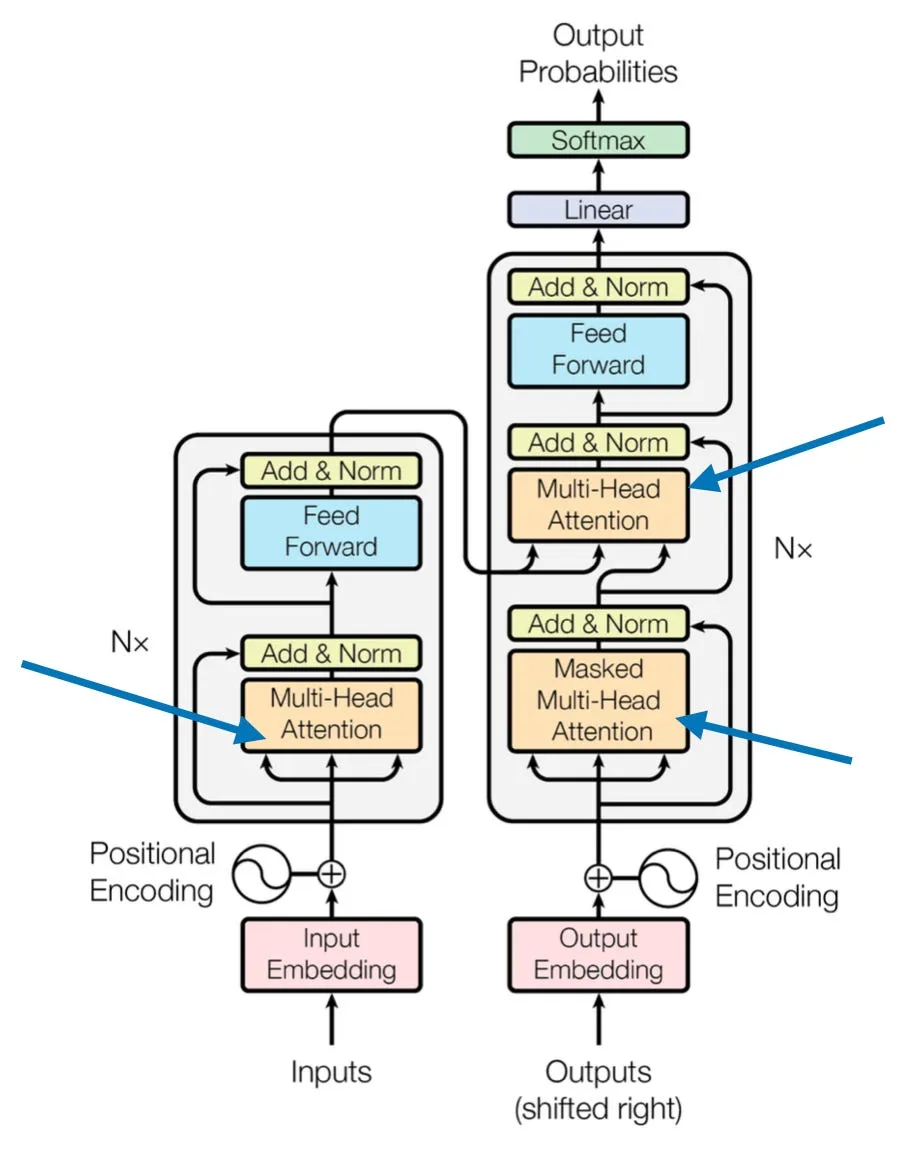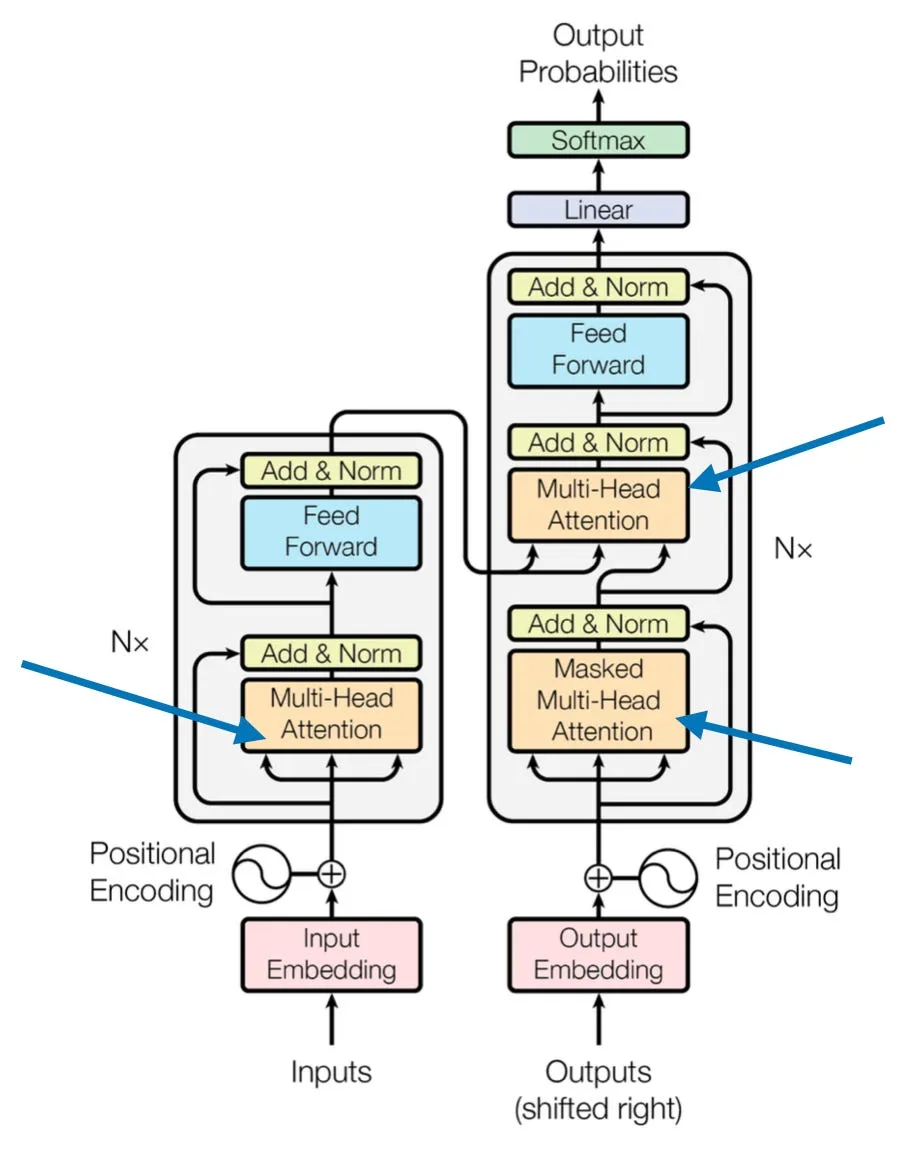

### Concept of Multi-Head Attention
In multi-head attention:

1. We create multiple sets of Query, Key, and Value weight matrices.
2. Each set forms an “attention head”.
3. Each head can potentially focus on different aspects of the input sequence.
4. The outputs from all heads are concatenated and linearly transformed to produce the final output.

This approach allows the model to capture various types of relationships and patterns in the data simultaneously.

### Implementing Multi-Head Attention

Let’s implement a `MultiHeadAttentionWrapper` the class that uses our previously defined `SelfAttention` class:

In [23]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(d_in, d_out_kq, d_out_v)
            for _ in range(num_heads)
        ])
    
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads])
        

In [24]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 1
num_heads = 4

mha = MultiHeadAttentionWrapper(d_in, d_out_kq, d_out_v, num_heads)

context_vecs = mha(embedded_sentence)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[-0.0185],
        [ 0.4003],
        [-0.1827],
        [ 0.0668],
        [-0.1103],
        [ 0.1180],
        [ 0.0170],
        [ 1.7137],
        [-0.2060],
        [ 0.3534],
        [-0.1609],
        [ 0.6949],
        [ 0.1999],
        [ 1.3981],
        [-0.2393],
        [ 0.2322],
        [ 0.0079],
        [ 0.3157],
        [-0.0860],
        [ 1.0497],
        [-0.3167],
        [ 0.1008],
        [-0.2416],
        [ 0.2807]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([24, 1])


##Cross-Attention: Bridging Different Input Sequences

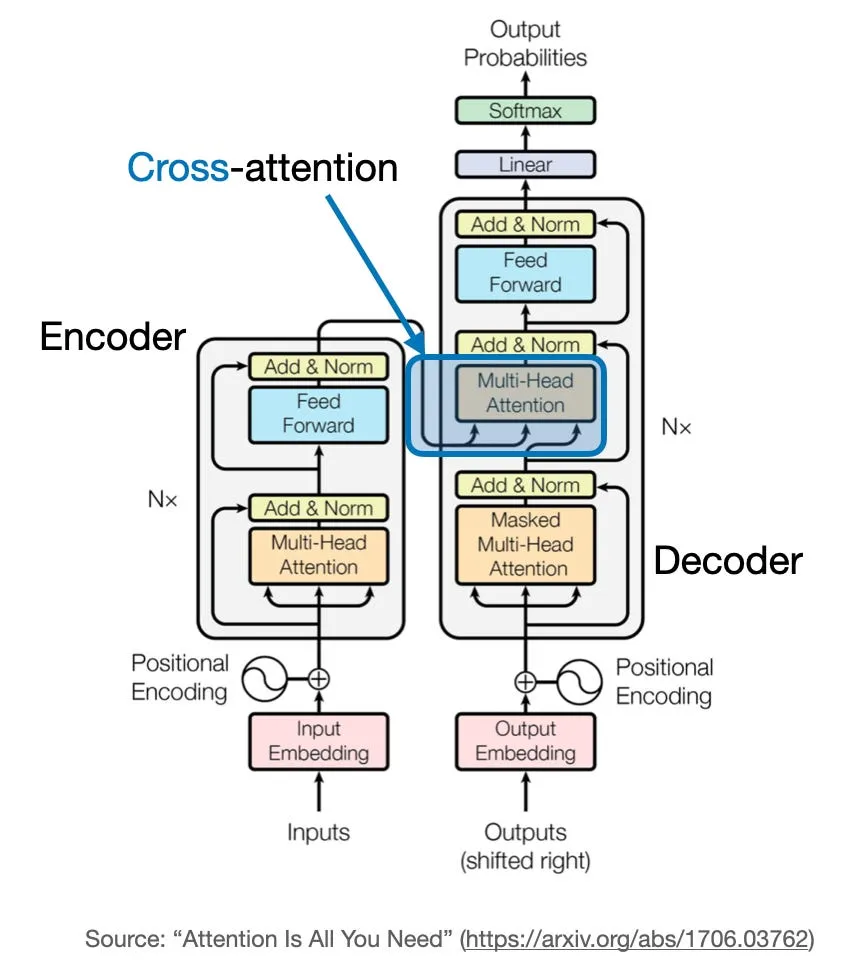

Cross-attention is a powerful variation of the attention mechanism that allows a model to process information from `two different input sequences`. This is particularly useful in scenarios where we want one sequence to inform or guide the processing of another. Let’s dive into the concept and implementation of cross-attention.


### Concept of Cross-Attention
In cross-attention:

1. We have two distinct input sequences.
2. Queries are generated from one sequence, while keys and values come from the other.
3. This allows the model to selectively focus on parts of one sequence based on the content of the other.
### Implementing Cross-Attention

In [25]:
class CrossAttention(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))
        
    def forward(self, x_1, x_2):
        queries_1 = x_1 @ self.W_query
        keys_2 = x_2 @ self.W_key
        values_2 = x_2 @ self.W_value
        
        attn_scores = queries_1 @ keys_2.T
        attn_weights = torch.softmax(attn_scores/self.d_out_kq**0.5, dim=-1)
        
        context_vec = attn_weights @ values_2
        return context_vec
                                

In [26]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

crossattn = CrossAttention(d_in, d_out_kq, d_out_v)

first_input = embedded_sentence
second_input = torch.rand(8, d_in)

print("First input shape:", first_input.shape)
print("Second input shape:", second_input.shape)

context_vectors = crossattn(first_input, second_input)

print(context_vectors)
print("Output shape:", context_vectors.shape)

First input shape: torch.Size([6, 3])
Second input shape: torch.Size([8, 3])
tensor([[0.4231, 0.8665, 0.6503, 1.0042],
        [0.4874, 0.9718, 0.7359, 1.1353],
        [0.3860, 0.8021, 0.5985, 0.9250],
        [0.4357, 0.8886, 0.6678, 1.0311],
        [0.4054, 0.8359, 0.6258, 0.9667],
        [0.4429, 0.9006, 0.6775, 1.0460]], grad_fn=<MmBackward0>)
Output shape: torch.Size([6, 4])


### Key Differences from Self-Attention
1. Two Input Sequences: Cross-attention takes two inputs, x_1 and x_2, instead of one.
2. Query-Key Interaction: Queries are derived from x_1, while keys and values come from x_2.
3. Flexible Sequence Lengths: The two input sequences can have different lengths.
### Applications of Cross-Attention
- Machine Translation: In the original Transformer model, cross-attention allows the decoder to focus on relevant parts of the source sentence while generating the translation.
- Image Captioning: The model can attend to different parts of an image (represented as a sequence of image features) while generating each word of the caption.
- Stable Diffusion: As mentioned, cross-attention is used to condition image generation on text prompts, allowing the model to incorporate textual information into the visual generation process.
- Question Answering: The model can attend to different parts of a context passage based on the content of the question.
### Advantages of Cross-Attention
1. Information Integration: Allows the model to selectively incorporate information from one sequence into the processing of another.
2. Flexibility: Can handle inputs of different lengths and modalities.
3. Interpretability: The attention weights can provide insights into how the model is relating different parts of the two sequences.
### Practical Considerations
- The embedding dimension (d_in) must be the same for both input sequences, even if their lengths differ.
- Cross-attention can be computationally intensive, especially with long sequences.
- Like self-attention, cross-attention can also be extended to a multi-head version for even more expressive power.
Cross-attention is a versatile tool that enables models to process information from multiple sources or modalities, making it crucial in many advanced AI applications. Its ability to dynamically focus on relevant information across different inputs contributes significantly to the success of models in tasks requiring the integration of diverse information sources.

## Causal Self-Attention(Masked Self-Attention)

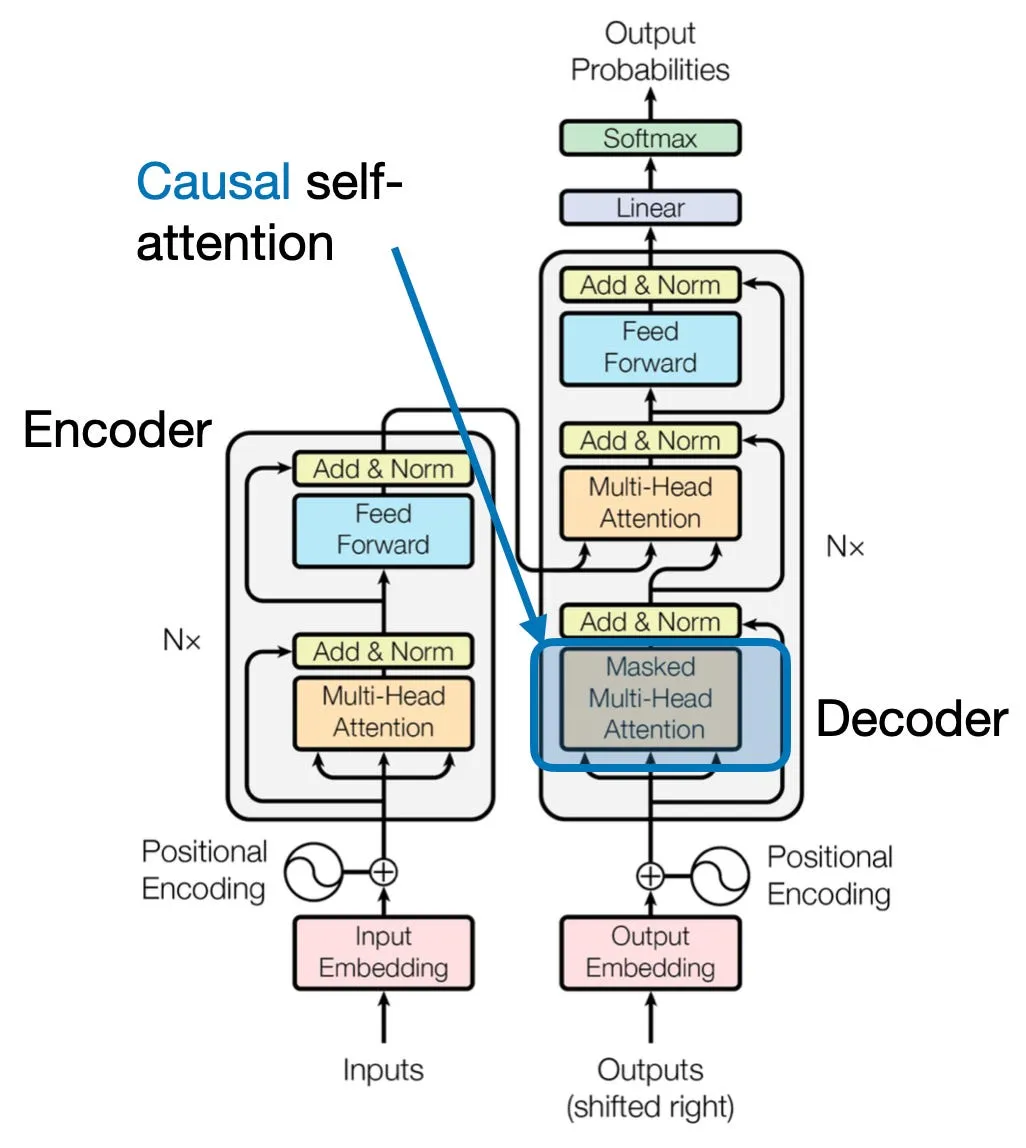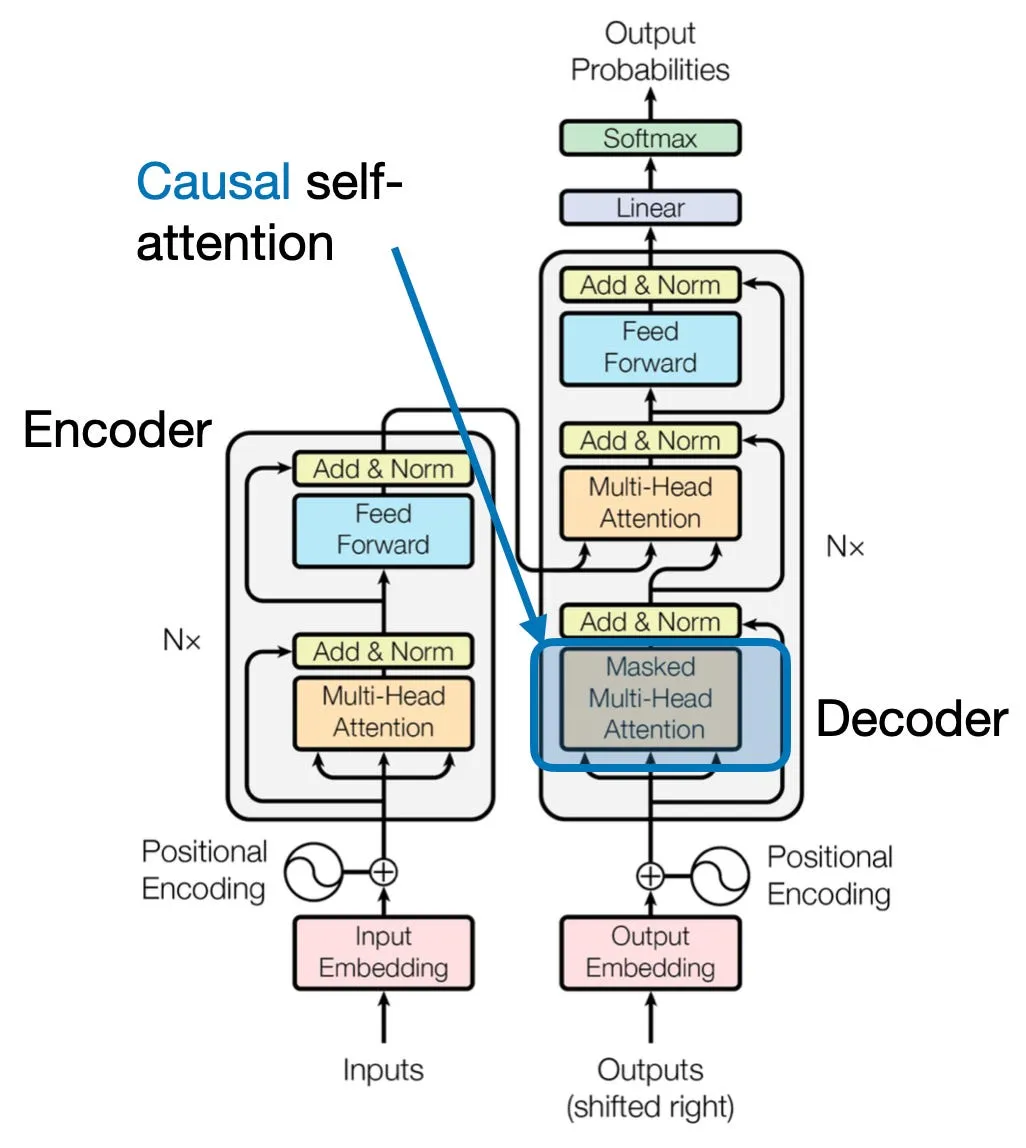

In this section, we're adapting the previously discussed self-attention mechanism into a causal self0attention mechanism, specifically for GPT-like(decoder-style) LLMs used in text generation. 

This mechanism is also known as 'masked self-attenion'. In the original transformer architecture, it corresponds to the 'masked multi-head attention' module. For simplicity, we'll focus on a single attention head, but the concept applies to multiple heads as well.

Causal self-attention ensures that the output for a given position in a sequence is based only on the known outputs at previous positions, not on future positions. In simpler terms, when predicting each next word, the model should only consider the preceding words. To achieve this in GPT-like LLMs, we mask out the future tokens for each token being processed in the input text.

To illustrate how this works, let's consider a. training text sample: "The cat sits on the mat". In causal self-attention, we'd have the following setup, where the context vectors for the word to the right of the arrow should only incorporate itself and the previous words:

“The” → “cat”

“The cat” → “sits”

“The cat sits” → “on”

“The cat sits on” → “the”

“The cat sits on the” → “mat”

This setup ensures that when generating text, the model only uses the information it would have available at each step of the generation process.


Recapping the computation of attention scores from the previous Self-Attention section

In [27]:
torch.manual_seed(123)

d_in, d_out_kq, d_out_v = 3, 2, 4

W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
W_key = nn.Parameter(torch.rand(d_in, d_out_kq))
W_value = nn.Parameter(torch.rand(d_in, d_out_v))

x = embedded_sentence

keys = x @ W_key
queries = x @ W_query
values = x @ W_value

attn_scores = queries @ keys.T 

print(attn_scores)
print(attn_scores.shape)

tensor([[ 0.0613, -0.3491,  0.1076, -0.0437,  0.1443, -0.1303],
        [-0.6004,  3.4707, -1.3374,  0.4991, -1.5023,  1.2903],
        [ 0.4344, -2.5037,  0.9265, -0.3509,  1.0740, -0.9315],
        [-0.0794,  0.4487, -0.1197,  0.0518, -0.1807,  0.1677],
        [ 0.2432, -1.3934,  0.4730, -0.1851,  0.5869, -0.5191],
        [-0.1510,  0.8626, -0.2787,  0.1112, -0.3597,  0.3216]],
       grad_fn=<MmBackward0>)
torch.Size([6, 6])


In [28]:
attn_weights = torch.softmax(attn_scores / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[0.1772, 0.1326, 0.1831, 0.1645, 0.1879, 0.1547],
        [0.0386, 0.6870, 0.0229, 0.0840, 0.0204, 0.1470],
        [0.1973, 0.0247, 0.2794, 0.1132, 0.3102, 0.0751],
        [0.1505, 0.2187, 0.1463, 0.1651, 0.1401, 0.1793],
        [0.1965, 0.0618, 0.2312, 0.1452, 0.2506, 0.1146],
        [0.1347, 0.2758, 0.1231, 0.1621, 0.1162, 0.1881]],
       grad_fn=<SoftmaxBackward0>)


**To implement causal self-attention, we need to mask out all future tokens. The simplest way to do this is by applying a mask to the attention weight matrix above the diagonal. We can achieve this using PyTorch’s tril function:**



In [29]:
block_size = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(block_size, block_size))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Now, we multiply the attention weights with this mask to zero out all the attention weights above the diagonal:


In [30]:
masked_simple = attn_weights * mask_simple
print(masked_simple)

tensor([[0.1772, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0386, 0.6870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1973, 0.0247, 0.2794, 0.0000, 0.0000, 0.0000],
        [0.1505, 0.2187, 0.1463, 0.1651, 0.0000, 0.0000],
        [0.1965, 0.0618, 0.2312, 0.1452, 0.2506, 0.0000],
        [0.1347, 0.2758, 0.1231, 0.1621, 0.1162, 0.1881]],
       grad_fn=<MulBackward0>)


**However, this approach leaves us with attention weights in each row that don’t sum to one anymore. To address this, we can normalize the rows:**

In [31]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3935, 0.0493, 0.5572, 0.0000, 0.0000, 0.0000],
        [0.2211, 0.3213, 0.2149, 0.2426, 0.0000, 0.0000],
        [0.2220, 0.0698, 0.2612, 0.1640, 0.2831, 0.0000],
        [0.1347, 0.2758, 0.1231, 0.1621, 0.1162, 0.1881]],
       grad_fn=<DivBackward0>)


Now the attention weights in each row sum up to 1, which is a standard convention for attention weights.

There’s a more efficient way to achieve the same results. Instead of masking the attention weights after softmax, we can mask the attention scores before applying softmax:

In [32]:
mask = torch.triu(torch.ones(block_size, block_size), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[ 0.0613,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.6004,  3.4707,    -inf,    -inf,    -inf,    -inf],
        [ 0.4344, -2.5037,  0.9265,    -inf,    -inf,    -inf],
        [-0.0794,  0.4487, -0.1197,  0.0518,    -inf,    -inf],
        [ 0.2432, -1.3934,  0.4730, -0.1851,  0.5869,    -inf],
        [-0.1510,  0.8626, -0.2787,  0.1112, -0.3597,  0.3216]],
       grad_fn=<MaskedFillBackward0>)


Now we apply softmax to get the final attention weights:



In [33]:
attn_weights = torch.softmax(masked / d_out_kq**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0532, 0.9468, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3935, 0.0493, 0.5572, 0.0000, 0.0000, 0.0000],
        [0.2211, 0.3213, 0.2149, 0.2426, 0.0000, 0.0000],
        [0.2220, 0.0698, 0.2612, 0.1640, 0.2831, 0.0000],
        [0.1347, 0.2758, 0.1231, 0.1621, 0.1162, 0.1881]],
       grad_fn=<SoftmaxBackward0>)


This approach is more efficient because it avoids unnecessary computations for masked-out positions and doesn’t require renormalization. The softmax function effectively treats the -inf values as zero probability because e^(-inf) approaches 0.

By implementing causal self-attention in this way, we ensure that our language model can generate text in a left-to-right manner, considering only the previous context when predicting each new token. This is crucial for producing coherent and contextually appropriate sequences in text generation tasks.